# Clustering Montreal's Bixi Bikeshare Stations based on Location and Usage Patterns

Bikeshare systems have become a staple of public transit in many large cities around the world. The concept is simple: stations are located across different parts of a city holding bikes that can be rented by members of the public. Riders check a bike out from one station, use it for transit, and then deposit it at a station close to their final destination. This system has been in place for several years now, and shows great popularity. Montreal Bixi bikes recorded [1M+ rides](https://www.cbc.ca/news/canada/montreal/jump-bikes-one-month-montreal-1.5233815) in July 2019. Washington DC's Capital Bikeshare notched 330K in May of the same year. NYC's Citi bikes recorded ridership of [over 2M](https://d21xlh2maitm24.cloudfront.net/nyc/June-2019-Citi-Bike-Monthly-Report.pdf?mtime=20190913182509) in June 2019. The system is evidently very popular.

Most of the cities running such a program publish data about the rides in their system, and that provides an opportunity for us to study the data to see if there's something of interest we can find. In this analysis, I am using data from Montreal's Bixi Bikeshare program which is extremely popular owning to several factors including the great inherent popularity of cycling as a method of transit in the city.

I do some basic analysis of basic features about the Bixi system, and then I use clustering algorithms to attempt to find clusters of stations that are related to each other. I am able to find some geographic and temporal patterns in how the Bixi system works which would be of great interest to the STM transit authority, the municipality, and other stakeholders. Particularly, I am able to identify patterns of commuter usage that riders take from residential to commerical/business areas and back, depending on the time of day.

### Previous Literature

The availability of bikeshare data from many different cities has provided a rich group of datasets that has been explored plenty by academic researchers and other interested individuals. [El-Assi, Mahmoud, and Habib (2017)](https://link.springer.com/article/10.1007/s11116-015-9669-z) finds that the weather and biking infrastructure are significant contributors to bikeshare usage in Toronto. [Zamir, Shafahi, and Haghani (2017)](https://pdfs.semanticscholar.org/05bd/09f07f3dbca6295c18a353793ca2a70bb266.pdf) use clustering algorithms to find clusters of similar bikeshare stations in Washington DC. They use their findings to make recommmendations to optimize balancing efforts of bike data. Todd W. Schneider analyzed [NYC's Citi bikeshare](https://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/) data and found usage in the outer boroughs of the city peaked in the early morning while usage in Manhattan peaked in the afternoon, matching a commuter pattern of riders using the bikes in their commutes. [This](https://towardsdatascience.com/understanding-bixi-commuters-an-analysis-of-montreals-bike-share-system-in-python-cb34de0e2304) post by Gregoire C-M uses spectral analysis on Montreal's Bixi data to find nodes (i.e. groups) of station usage that can help identify patterns in how users take trips around the city. 

My work here attempts to identify clusters of usage similar to the work of Zamir, Shafahi, and Haghani while finding different robustness checks to ensure that my findings conclusions make sense.

### Data

I am using [2019 data](https://www.bixi.com/en/open-data) which begins in April and runs until the most recent data available at the time of my writing which is October data. Montreal's Bixi stations are removed every year on [November 15th](https://montreal.bixi.com/en/where-do-all-the-bixi-go-in-the-winter) so we aren't excluding that much data for the year doing the analysis now. The data is composed of several CSV files divided by month, with another CSV file listing the stations that were active during the year. I will discuss the data available from those CSV files momentarily once we load and start exploring the data. 

It's worth noting that Bixi, as do other bikeshare systems, provides [real-time system data](https://api-core.bixi.com/gbfs/gbfs.json) in the form of live JSON files which can be called through an API call (using for example Python's *requests* library). I have used similar feeds when analyzing data for other cities, but since I have data for the 2019 stations I can save myself the slightest bit of work.

The secret to success, after all, is being as lazy as possible under the circumstances! 😃

General documentation for bikeshare feed data can be found [here](https://github.com/NABSA/gbfs).

### Libraries

Since I am using Python, I naturally use Pandas for the bulk of my data processing.

I use scikit-learn to perform cluster analysis as it is a standard machine learning library in Python.

I use Montreal's very own Plotly to graph and map my results. I love Plotly and their products. They've become pretty intuitive, and their dashboard library, Plotly Dash, is extremely impressive and I've used it extensively to create powerful dashboard tools. If you've never tried their library, give it a whirl!

I also use Numpy and os very briefly.

### A Note on domain knowledge and familiarity with the city

I want to put a disclaimer here that I've only visited Montreal twice and have never lived there, so obviously my knowledge of the city will be quite limited to what most outsiders know of the city. Of course, that presents a challenge as what I call different areas and how I interpret my results might not make sense to someone who knows the city well. Domain knowledge is extremely important as it provides a guide as to which questions are interesting and whether any results make sense or not. And I obviously lack that. With that in mind, I'll try to limit my statements or assumptions only to what I can verify through the data or through other sources.

And with that, I think we're ready to dive into the analysis.

In [1]:
from IPython.display import Image
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import os

# I've recently been stung by not explicitly specifying the file encoding I use to 
# read/write files, and as such I've become pretty stickler for specifying a
# file's encoding. This is essential in Montreal's case due to French letter 
# diacritics. 

# I first begin by loading the station info.
stationInfo = pd.read_csv('data/montreal/Stations_2019.csv',encoding='utf8')

fileList = os.listdir('data/montreal')
# I'll use the directory listing list to more easily load the separate CSV files 
# into one dataframe
print(fileList)

['BixiMontrealRentals2019.zip', 'OD_2019-04.csv', 'OD_2019-05.csv', 'OD_2019-06.csv', 'OD_2019-07.csv', 'OD_2019-08.csv', 'OD_2019-09.csv', 'OD_2019-10.csv', 'Stations_2019.csv']


In [2]:
data = pd.concat([pd.read_csv('data/montreal/'+fileName,encoding='utf8')
                  for fileName in fileList[1:-1]],
                 sort=False,ignore_index=True)

data.loc[:,'start_date'] = pd.to_datetime(data['start_date'])
data.loc[:,'end_date'] = pd.to_datetime(data['end_date'])
data['tripStartHour'] = data['start_date'].dt.hour

C:\Users\natou\Anaconda3\envs\capBikeshare\lib\site-packages\IPython\core\interactiveshell.py:3183: DtypeWarning:

Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.



### Data Exploration

Now that we've loaded the data, let's do some basic exploration.

Here is a sample of what the station data looks like. It lists the station's name, its numerical code, and its latitude and longitude data. 

In [3]:
stationInfo.head()

,Code,name,latitude,longitude
0,10002,Métro Charlevoix (Centre / Charlevoix),45.478228,-73.569651
1,4000,Jeanne-d'Arc / Ontario,45.549598,-73.541874
2,4001,Graham / Brookfield,45.520075,-73.629776
3,4002,Graham / Wicksteed,45.516937,-73.640483
4,5002,St-Charles / Montarville,45.533682,-73.515261


Here's what the trip data looks like. It is a listing of all the trips in the system made by users. Each row is a unique trip, listing the starting station code and starting time of the trip, the ending station code and ending time of the trip, the duration of the trip in seconds, and whether the trip was taken by a member.

In [4]:
data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,tripStartHour
0,2019-04-14 07:55:22,6001,2019-04-14 08:07:16,6132,713,1,7
1,2019-04-14 07:59:31,6411,2019-04-14 08:09:18,6411,587,1,7
2,2019-04-14 07:59:55,6097,2019-04-14 08:12:11,6036,736,1,7
3,2019-04-14 07:59:57,6310,2019-04-14 08:27:58,6345,1680,1,7
4,2019-04-14 08:00:37,7029,2019-04-14 08:14:12,6250,814,0,8


Let's get some descriptive stats about trip duration and membership of the riders. We see that 82% of rides are taken by members: that is, riders who have subscribed to the Bixi system which allows them to ride for free or reduced prices. Meanwhile, the average trip takes around 13.5 minutes. The bikeshare systems generally remove any trips with duration of 60 seconds or less as they believe that those trips are noise. We can see that reflected in the minimum figure for trips that only start at 61 seconds. Most trips take no longer than 45 minutes, as evident by the 99th percentile of the data. This suggests a usage patter associated with commuting as opposed to toursism/exploration/fun rides.

In [5]:
data[['duration_sec','is_member']].describe().style.format('{:.2f}')

,duration_sec,is_member
count,5597845.00,5597845.00
mean,811.28,0.82
std,625.16,0.38
min,61.00,0.00
25%,369.00,1.00
50%,648.00,1.00
75%,1090.00,1.00
max,7199.00,1.00


In [6]:
data['duration_sec'].quantile(0.99)

2842.0

Let's graph the stations on a map.

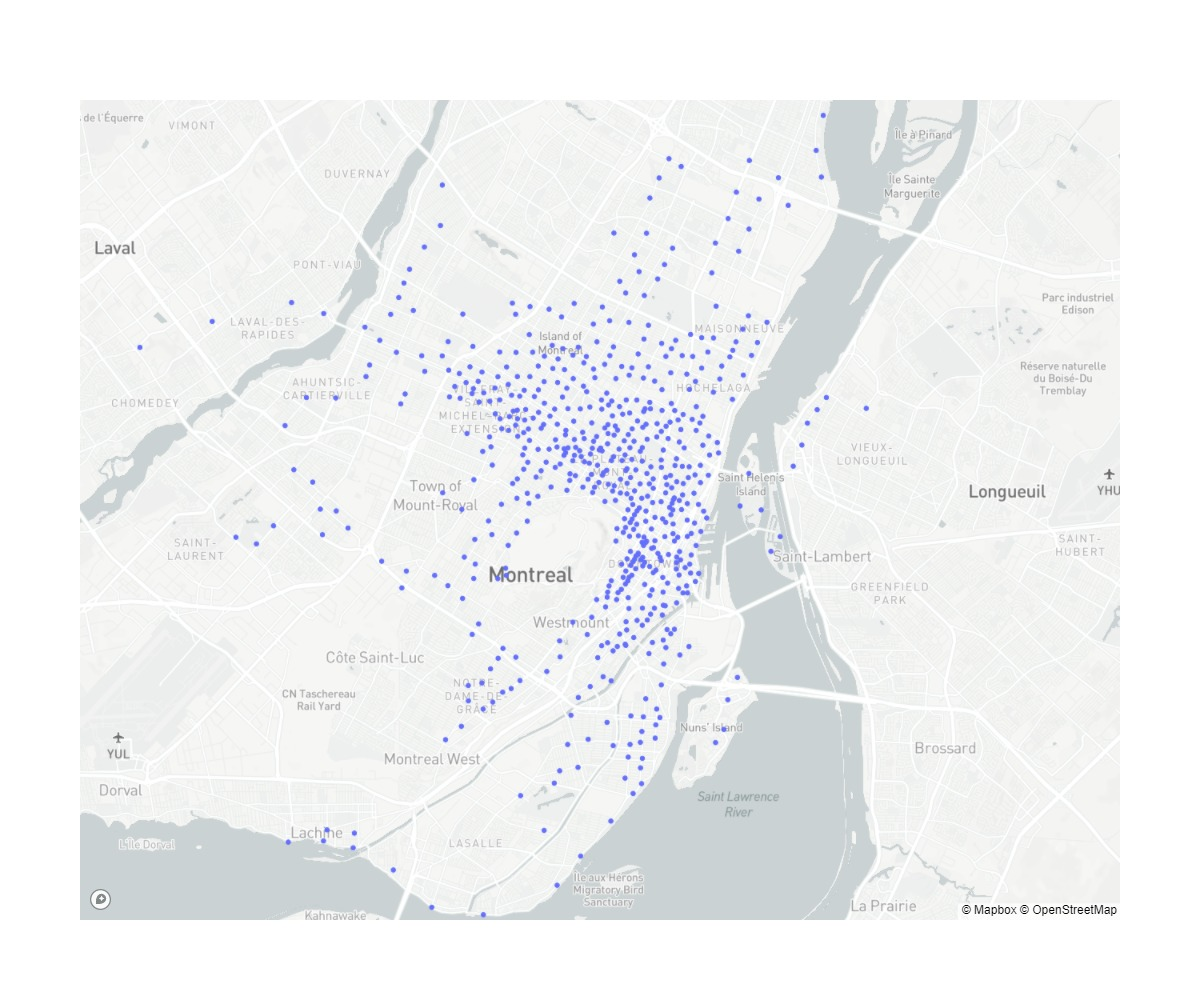

In [15]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
        lat=stationInfo['latitude'],
        lon=stationInfo['longitude'],
        text=stationInfo['name']
    )
)

fig.update_layout(
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=open('mapboxToken.txt','r').read(),
        center=go.layout.mapbox.Center(
            lat=stationInfo['latitude'].mean()-0.0075,
            lon=stationInfo['longitude'].mean()),
        zoom=11
        )    
)

# fig.show()
img_bytes = fig.to_image(format="jpg",width=1200,height=1000)
Image(img_bytes)

We can see that the stations are located throughout the city with a few stations located in nearby Longueuil and Laval. The bulk of the stations are located in the Downtown, Old Montreal, and Plateau Mont-Royal areas. More stations stretch into the Mile End, Villeray, and Little Italy neighborhoods. We can easily identify the Mont-Royal park/hill as it is the area in the middle of the city that lacks bikeshare stations. Finally a few stations are located in Pole des Rapides and the north end of the island. 

What does the usage pattern for all stations look like? Let's do a histogram of trip starts based on the hour of the day in which that occurs.

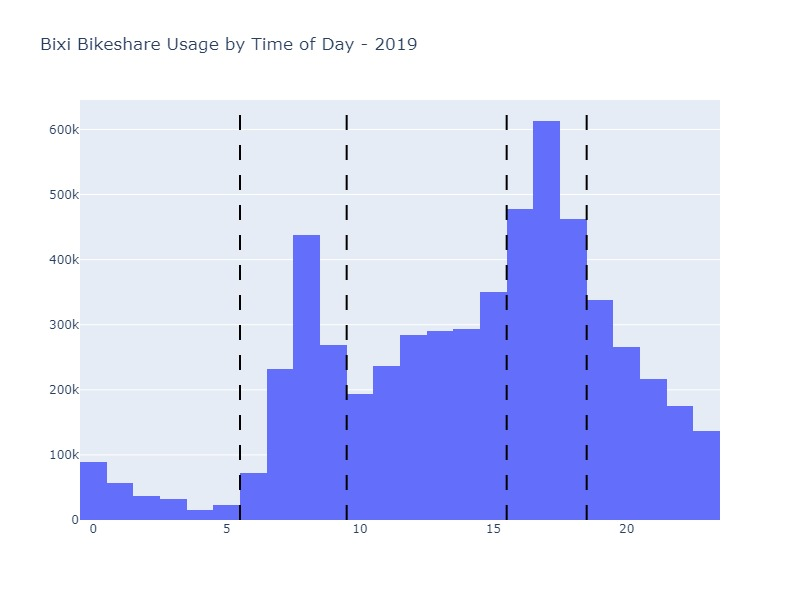

In [11]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=data['tripStartHour']))
fig.update_layout(title='Bixi Bikeshare Usage by Time of Day - 2019',
    shapes=[
    go.layout.Shape(
        type='line',
        yref='paper',
        x0=x,
        x1=x,
        y0=0,
        y1=1,
        line={'color':'black','dash':'longdash'}
    )
    for x in [5.5,9.5,15.5,18.5]]
)

# fig.show()

Image(fig.to_image(format="jpg",width=800,height=600))

We can see that usage varies depending on the time of day. And based on this variation, we can come up with time bins for when a ride takes place: midnight (12AM through 5 AM), morning rush hour (6AM through 9AM), day (10AM through 3PM), evening rush hour (4PM through 6PM), and night (7PM and after). I have marked those time bins using the dashed black lines. This will become important for us when we get to clustering.

That's interesting, let's dig through some more! Is there variation in usage based on the time of the week and whether the riders are members or not?

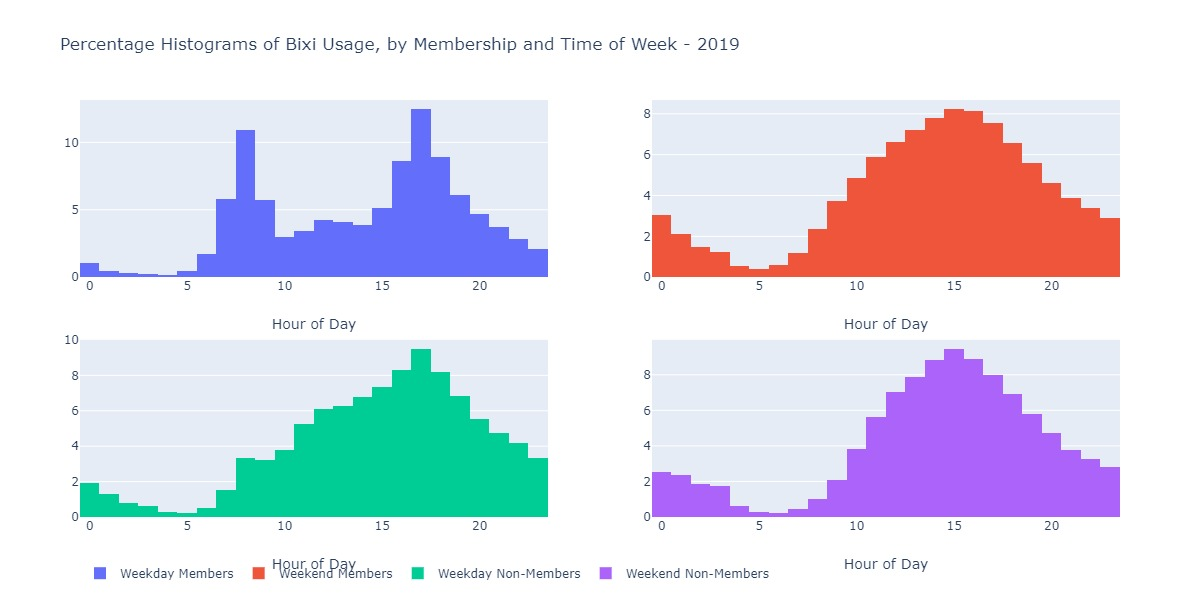

In [12]:
fig = make_subplots(rows=2, cols=2)

rowsCols = [(1,1),(1,2),(2,1),(2,2)]
labels = ['Weekday Members','Weekend Members','Weekday Non-Members','Weekend Non-Members']


member = (data['is_member']==1)
nonmember = (data['is_member']==0)
weekday = (data['start_date'].dt.weekday<5)
weekend = (data['start_date'].dt.weekday>=5)
masks = [(member & weekday),(member & weekend),(nonmember & weekday),(nonmember & weekend)]

for mask,label,rowCol in zip(masks, labels, rowsCols):
    fig.add_trace(go.Histogram(
            x=data.loc[mask,'tripStartHour'],
            histnorm='percent',
            name=label),
        row=rowCol[0],col=rowCol[1])

fig.update_layout(title='Percentage Histograms of Bixi Usage, by Membership and Time of Week - 2019',
                 legend_orientation='h')
fig.update_xaxes(title='Hour of Day',)
# fig.show()
Image(fig.to_image(format="jpg",width=1200,height=600))

We can see that usage by members during the week most closely matches that of the overall system, implying that membership usage during the week forms the bulk of the system's usage. But outside of the week, usage by members and non-members seems to be similar. 

We can confirm the importance of weekday member usage to the system by finding out how many rides fit that criterion.

In [13]:
f'{data[member&weekday].shape[0]/data.shape[0]:.2%}'

'64.22%'

64% of all rides are taken by members during the week. This fits Montreal's reputation as a bike-friendly city since its member residents seem to be biking heavily.

We can also do a similar analysis based on the time of the year.

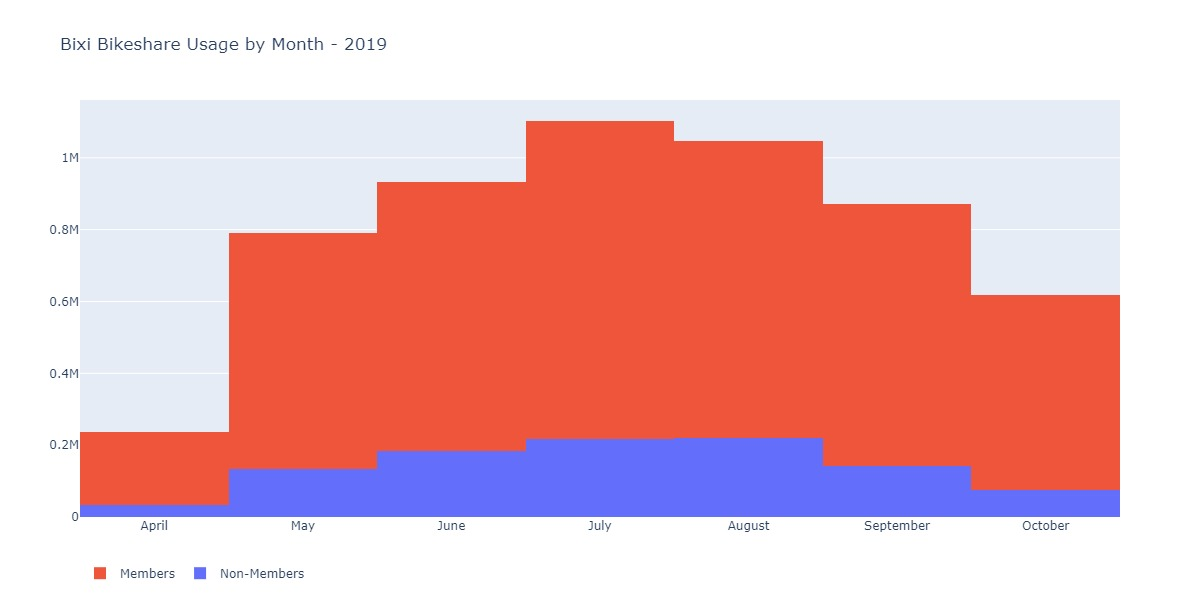

In [14]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=data.loc[data['is_member']==0,'start_date'].dt.month,
                           name='Non-Members',
#                           marker_color='red'
                          ))
fig.add_trace(go.Histogram(x=data.loc[data['is_member']==1,'start_date'].dt.month,
                           name='Members',
#                           marker_color='blue'
                          ))

fig.update_layout(title='Bixi Bikeshare Usage by Month - 2019',
                  legend_orientation='h',
                barmode='stack')
fig.update_xaxes(tickmode='array',
                 tickvals=list(range(4,11)),
                 ticktext=['April','May','June','July',
                             'August','September','October'])
# fig.show()
Image(fig.to_image(format="jpg",width=1200,height=600))

The results look like what we expect them to. Raw bike usage starts out low in April, when the weather may still not be conducive to biking. I don't believe that that number is affected by the time the system is available, since the Bixi system opened on April 15th this year. As weather improves, ridership dramatically increases throughout the summer. As the weather gets colder, usage starts to drop again. 

### Clustering Strategy

As we have seen from the map, while the bulk of stations is located in one big blob in the city core, many stations are spread farther out. This will probably present us with a challenge as to how to cluster those stations which might make my results less fuzzy. Thus I will have to determine which stations should be included in our analysis and which ones are just too far away from the bulk and thus can be discarded.

The way I will do so is by using the DBSCAN clustering algorithm to find geographic clusters of stations. The rest is discarded as noise. The advantage of the DBSCAN algorithm is that I don't have to myself specify the number of clusters that I think is appropriate, which somewhat takes out of my hand the choice of which stations to use and which to discard. I will then use a k-means clustering algorithm on the reduced stations data but with all features. Doing so allows me to find stations that are geographically close to each other and have similar usage patterns. 

Let's start analyzing our data. Since weekday member ridership forms a unique and significant usage pattern, I will only use it as the only data in my analysis. By doing so, it is more likely for me to find patterns in my analysis. I will aggregate that data by station and time of day into a pivot table showing the number of trips that start at a given station at a given hour. 

In [16]:
stationsByStart = pd.pivot_table(data[member&weekday],index=['start_station_code','tripStartHour'],aggfunc='count')['start_date'].reset_index().rename(columns={'start_station_code':'station','start_date':'count'})

I want to ensure that every station has a rows of all the hours of the day. As such, I construct a dataframe with all the start station codes in our dataset and the hours in the day then join the pivot table dataframe on it. Any blanks will be NaN, and we can obviously fill those with zeros. 

In [17]:
uniqueStations = list(set(stationsByStart['station']))

# repeat every station code 24 times, then take a modulus of the index by 24 
# to produce a series with repeating hours during the day
tripHourCounts = pd.DataFrame({'station':np.repeat(uniqueStations,24)}).reset_index()
tripHourCounts.loc[:,'index'] = tripHourCounts['index'] % 24

tripHourCounts.rename(columns={'index':'tripStartHour'},inplace=True)
tripHourCounts = pd.merge(tripHourCounts,stationsByStart,on=['station','tripStartHour'],how='left').rename(columns={'count':'starts'}).fillna(0)

dayCategories = ['midnight','morning rush hour','day','evening rush hour','night']
tripHourCounts.loc[:,'category'] = pd.cut(tripHourCounts['tripStartHour'],
                                          [0,5,9,15,18,23],
                                          labels=dayCategories,
                                          include_lowest=True)

There seems to be a faulty station code that might be a test trip that was not cleaned up. I remove it here to aid in merging the dataframes more easily. I do so by detecting text characters it contains text characters instead of being fully numerical to remove it. As it is only three trips, it does not affect our analysis at all.

In [18]:
tripHourCounts[~(tripHourCounts['station'].astype('str').str.isnumeric())&tripHourCounts['starts']>0]

,tripStartHour,station,starts,category
7234,10,MTL-ECO5.1-01,1.0,day
7235,11,MTL-ECO5.1-01,1.0,day
7236,12,MTL-ECO5.1-01,1.0,day


In [19]:
tripHourCounts = tripHourCounts[(tripHourCounts['station'].astype('str').str.isnumeric())]
tripHourCounts.loc[:,'station'] = tripHourCounts['station'].astype('int')

I then classify each hour row into one part of the day

In [20]:
dayCategories = ['midnight','morning rush hour','day','evening rush hour','night']
tripHourCounts.loc[:,'category'] = pd.cut(tripHourCounts['tripStartHour'],
                                          [0,5,9,15,18,23],
                                          labels=dayCategories,
                                          include_lowest=True)

I want to use the relative usage of a station during each part of the day as a feature to consider when clustering. Thus, I will reshape the station dataframe into a "wide" dataframe, then I will join it on the stationInfo dataframe, which contains latitude and longitude data. The information about usage for each station during a part of the day will still be a raw count of the number of rides that started at that location, so I will need to normalize it. I do so by converting those raw rides in each part of the day into percentages of the total number of rides taken at that station. Finally, in order to use the DBSCAN algorithm, I need to normalize the latitudes and longitudes of the stations as well. I do so by using a MinMax scaler which scales the data points based on the minimum and maximum of the data series.

In [21]:
tripHourCounts = tripHourCounts.groupby(['station','category'])['starts'].sum().reset_index().pivot(index='station',columns='category',values='starts')
clusteringData = pd.merge(stationInfo[['Code','latitude','longitude']],tripHourCounts,right_on='station',left_on='Code')

total = clusteringData[dayCategories].sum(axis=1)

clusteringData.loc[:,dayCategories] = clusteringData.divide(total,axis=0)
clusteringData.loc[:,['latitude','longitude']] = preprocessing.MinMaxScaler().fit_transform(clusteringData[['latitude','longitude']])
clusteringData = clusteringData.dropna()

As everywhere in the machine learning space, the choice of parameters is essential to ensuring that we obtain reasonable results. In the case of the DBSCAN algorithm, there are two parameters that interest us: epsilon and minimum cluster size. Epsilon is the maximum threshold for the distance between two points in order for them to be considered to be in the same cluster. A point is assigned to a cluster based on whether the distance between that datapoint and one of the cluster's datapoints is within that maximum threshold. The minimum cluster size ensures that the number of clusters doesn't spiral out of control by making sure a group of points is of a minimum size before it is considered a cluster. Tuning these parameters is essential to, as objectively as possible, finding a "bulk" of stations.

Since epsilon is a maximum distance, it makes sense to figure out what are the distances between different points generally looks like. As such, I will calculate the distance between each point and its nearest neighbor and pick an epsilon that is greater than most of the calculated distances. 

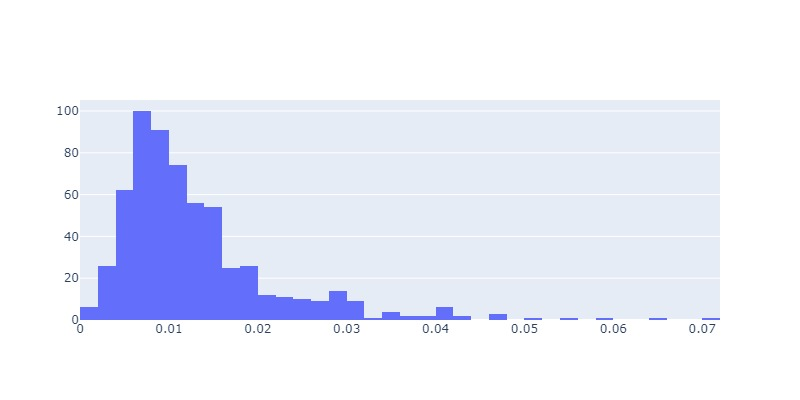

In [22]:
neigh = NearestNeighbors(n_neighbors=2).fit(clusteringData.iloc[:,1:3])
distances, _ = neigh.kneighbors(clusteringData.iloc[:,1:3])
x = np.sort(np.mean(distances,axis=1))

fig = go.Figure()
fig.add_trace(go.Histogram(x=distances[:,1]))

Image(fig.to_image(format="jpg",width=800,height=400))

There is no consensus on what an optimal minimum cluster size is. Thus I will leave it as the default 5. From that histogram, it seems that most distances are within 0.032. Another approach involves sorting the distances array in ascending order and finding where the leg has maximum curvature. The formula for curvature is $\kappa=\dfrac{|y''|}{(1+y'^{2})^{3/2}}$. We calculate the maximum curvature and then use that to find the appropriate epsilon as recommended by this method.

In [23]:
firstDeriv = np.gradient(x)
secondDeriv = np.gradient(firstDeriv)

curvature = (np.abs(secondDeriv)/((1+firstDeriv**2)**1.5))
maxCurv = np.max(curvature)

recommendedEps = x[np.where(curvature==maxCurv)]
print(recommendedEps[0])

0.023844506545012703


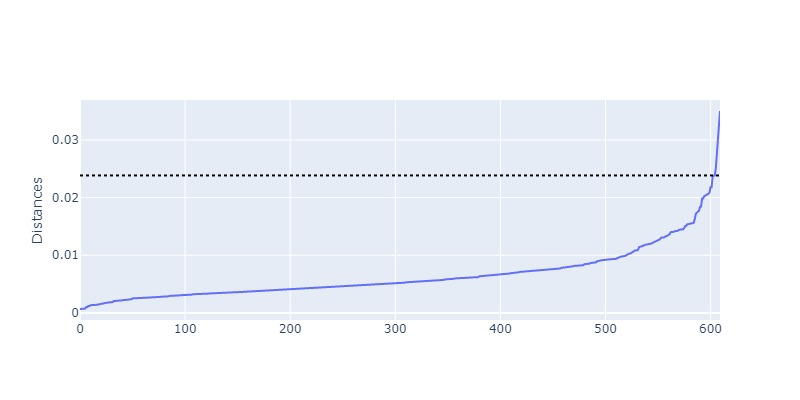

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,x.size),y=x))
fig.update_layout(shapes=[
    go.layout.Shape(
        type='line',
        y0=recommendedEps[0],
        y1=recommendedEps[0],
        xref='paper',
        x0=0,
        x1=1,
        line={'color':'black','dash':'dot'}
    )
])
fig.update_yaxes(title='Distances')

Image(fig.to_image(format="jpg",width=800,height=400))

The distances curve curvature method implies an optimal epsilon of 0.0234. In the interest of being conservative and minimizing the number of clusters, I will go with the smaller threshold. Epsilon = 0.0234 it is.

I run the model using the normalized geographic coordinates only. This takes away any spatial outliers. The different resulting clusters can be seen below, with stations labelled as noise in black. The algorithm is able to find 2 clusters based on geography. We don't care about those labels though: we're only using the algorithm to discard spatial outliers.

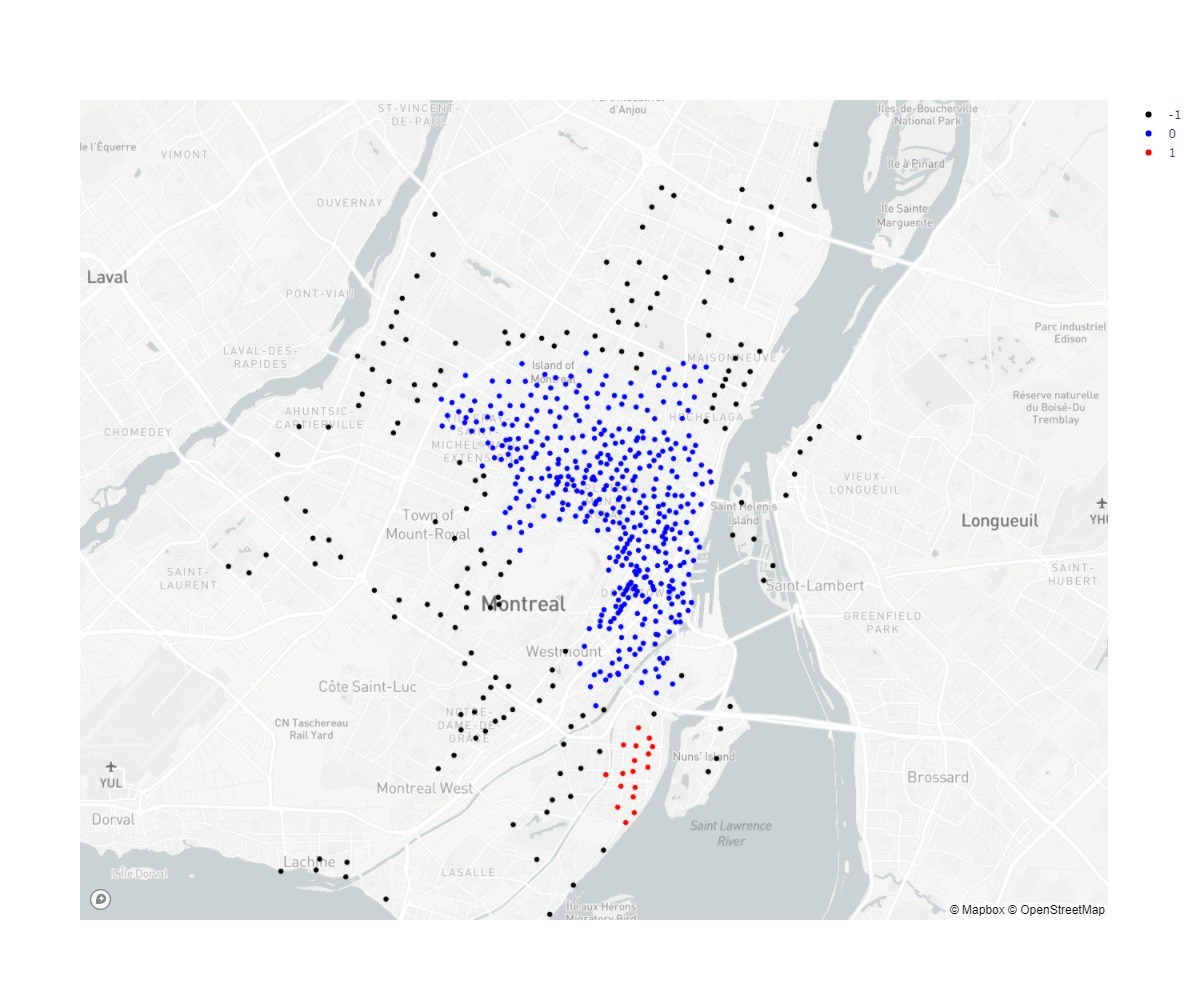

In [26]:
yhat = DBSCAN(eps=0.0234).fit_predict(clusteringData.iloc[:,1:3].values)
clusteringData.loc[:,'label'] = yhat

results = pd.merge(stationInfo,clusteringData[['Code','label']],on='Code')

fig = go.Figure()

clusterLabels = [x for x in np.sort(results['label'].unique(),-1)]

randomColourList = ['black','blue','red']

for clusterLabel,color in zip(clusterLabels,randomColourList):
    fig.add_trace(go.Scattermapbox(
        lat=results.loc[results['label']==clusterLabel,'latitude'],
        lon=results.loc[results['label']==clusterLabel,'longitude'],
        mode='markers',
        marker_color=color,
        hovertext=results['Code'],
        name=str(clusterLabel)
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=open('mapboxToken.txt','r').read(),
        zoom=11,
        center=go.layout.mapbox.Center(
            lon=results['longitude'].mean(),
            lat=results['latitude'].mean()
        )
    )

)

# fig.show()
img_bytes = fig.to_image(format="jpg",width=1200,height=1000)
Image(img_bytes)

In [27]:
stationsOfInterest = results.loc[results['label']!=-1,'Code'].unique()
stationsOfInterest.size

438

The DBSCAN algorithm leaves us with 438 stations, from the original 611. Yes, that is a sizable decrease, but since the majority of stations are still in our dataset, I argue that this will help our analysis.

A major weakness of unsupervised learning in general and clustering in particular is that we are not guaranteed a meaningful result. We're in a sense trying to find meaning in data, and that might lead to data mining and finding spurious correlations. In this case, a way to try to avoid that and be more confident in our results is to try to minimize the number of clusters we find. Seeing as DBSCAN is very sensitive to the choice of epsilon, it may be a better idea to pick a specific number of clusters that we want. This leads us to more simple algorithms. In the interest of simplicity, I picked k-means clustering, although sklearn's agglomerative clustering algorithm gave similar results. 

The question in tuning our model this time is determining the appropriate number of clusters. We can do so by examining the inertia of several iterations of the model using several possible values for the number of clusters. Inertia is defined as the sum of the squared distances of each point to their assigned cluster's centroid. Thus, a low inertia is "good" as it means that points in a cluster are close to each other/compact. On the other hand, we run the risk of reading too much into our data if we assign our datapoints into too many clusters. If there are a lot of centroids, then of course we're going to find a low inertia as there are more centroids to be closer to more isolated points. 

So there's a balancing act we need to follow, and again, there are no standardized right answers. A common heuristic is to use the "Elbow method". It is as follows: we'll find the inertia of several iterations of the algorithm under different cluster numbers, and we'll pick the one where it seems that the decrease in inertia seems to taper off. If we're lucky, the graph will look like it has an "elbow" and we can pick the model with the number of clusters accordingly.

In [28]:
uniqueStations = list(set(stationsByStart['station']))

# repeat every station code 24 times, then take a modulus of the index by 24 
# to produce a series with repeating hours during the day
tripHourCounts = pd.DataFrame({'station':np.repeat(uniqueStations,24)}).reset_index()
tripHourCounts.loc[:,'index'] = tripHourCounts['index'] % 24

tripHourCounts.rename(columns={'index':'tripStartHour'},inplace=True)

tripHourCounts = (pd.merge(tripHourCounts,
                          stationsByStart,
                          on=['station','tripStartHour'],
                          how='left')
                  .rename(columns={'count':'starts'}).fillna(0))

dayCategories = ['midnight','morning rush hour','day','evening rush hour','night']
tripHourCounts.loc[:,'category'] = pd.cut(tripHourCounts['tripStartHour'],
                                          [0,5,9,15,18,23],
                                          labels=dayCategories,
                                          include_lowest=True)


# as before, we remove the faulty station code

tripHourCounts = tripHourCounts[(tripHourCounts['station'].astype('str').str.isnumeric())]
tripHourCounts.loc[:,'station'] = tripHourCounts['station'].astype('int')

tripHourCounts = (tripHourCounts.groupby(['station','category'])['starts']
                  .sum().reset_index().pivot(index='station',columns='category',values='starts'))
clusteringData = pd.merge(
    stationInfo.loc[stationInfo['Code'].isin(stationsOfInterest),
                    ['Code','latitude','longitude']],
    tripHourCounts,right_on='station',left_on='Code')

total = clusteringData[dayCategories].sum(axis=1)

clusteringData.loc[:,dayCategories] = (clusteringData[dayCategories].divide(total,axis=0))
clusteringData.loc[:,['latitude','longitude']] = preprocessing.MinMaxScaler().fit_transform(clusteringData[['latitude','longitude']])

clusteringData = clusteringData.dropna()

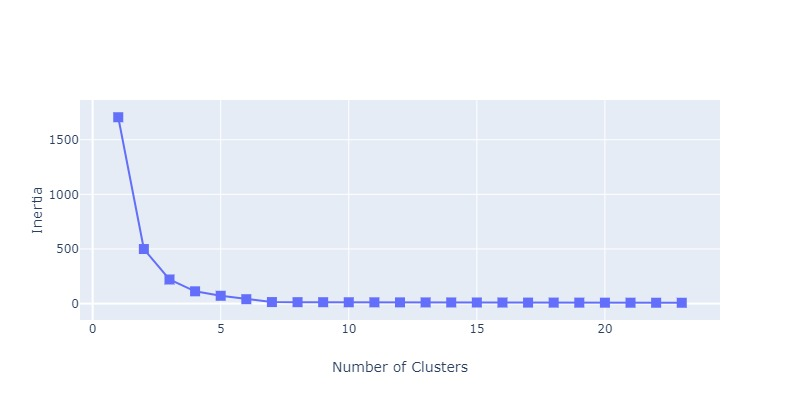

In [33]:
# clusteringData = clusteringData[clusteringData['Code'].isin(stationsOfInterest)].dropna()

ssm = [KMeans(n_clusters=x).fit(clusteringData.iloc[:,1:]).inertia_ for x in range(1,24)]
# silScores = [silhouette_score(clusteringData.iloc[:,1:],KMeans(n_clusters=x,tol=1e-6).fit(clusteringData.iloc[:,1:]).labels_) for x in range(2,16)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,24)),y=ssm,mode='lines+markers',marker=dict(symbol='square',size=10)))
fig.update_xaxes(title='Number of Clusters')
fig.update_yaxes(title='Inertia')
Image(fig.to_image(format="jpg",width=800,height=400))

Unfortunately, we don't have clear-cut results, with cluster sizes from 2 to 7 seeming appropriate. I tried those possibilities and it seems a cluster size of 7 generates the most interesting findings (though given that it's the largest cluster size I considered, I will have to make sure to head my own warnings of not falling for spurious results). Let's examine that cluster size.

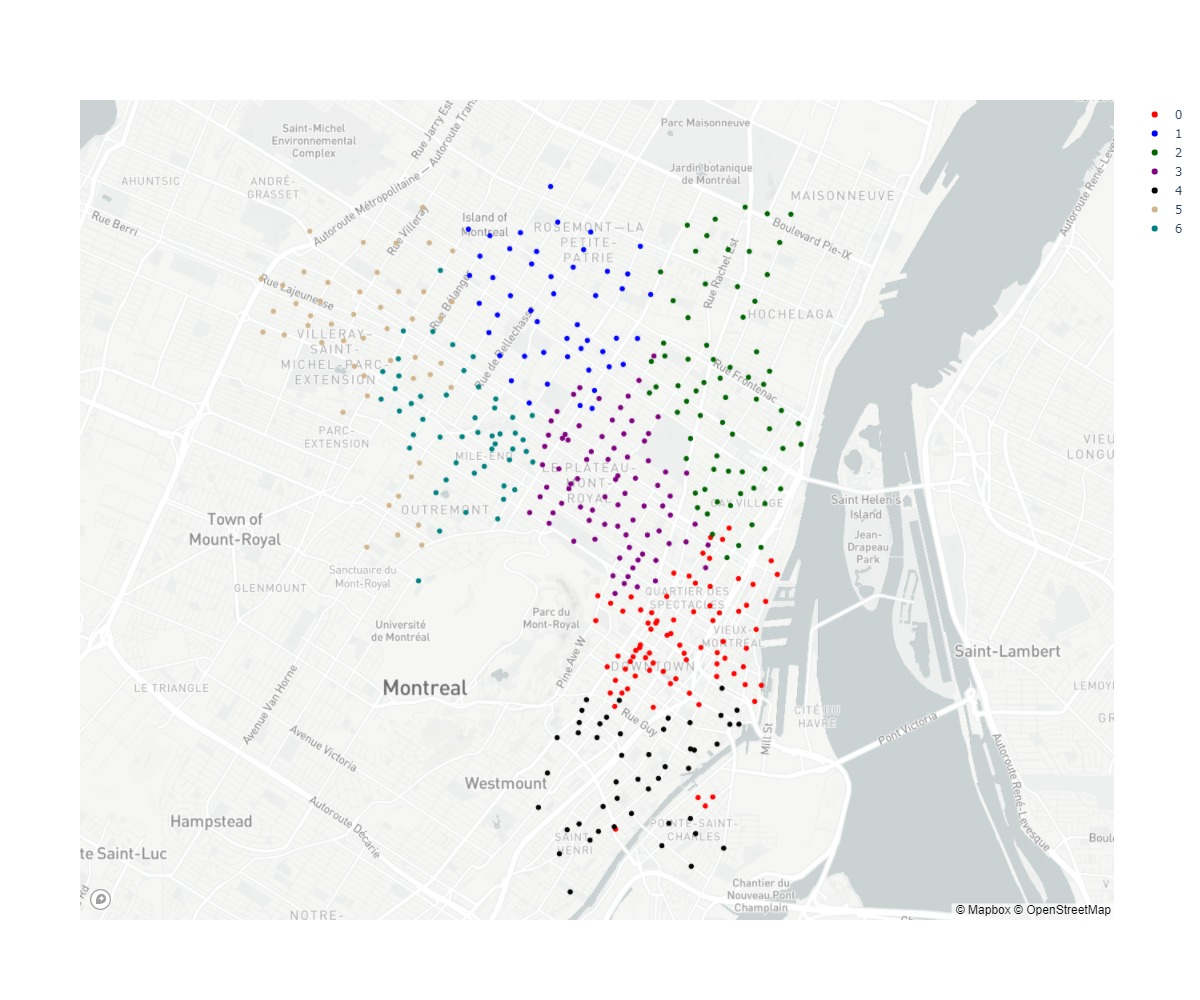

In [30]:
yhat = KMeans(n_clusters=7).fit_predict(
    clusteringData[clusteringData['Code'].isin(stationsOfInterest)].dropna().iloc[:,1:].values)
clusteringData.loc[:,'label'] = yhat

results = pd.merge(stationInfo,clusteringData[['Code','label']],on='Code')

fig = go.Figure()

clusterLabels = [x for x in np.sort(results['label'].unique(),-1) if x!=-1]

randomColourList = ['red','blue','darkgreen','purple','black',
                    'tan','teal','gold','orange','scarlet']

for clusterLabel,color in zip(clusterLabels,randomColourList):
    fig.add_trace(go.Scattermapbox(
        lat=results.loc[results['label']==clusterLabel,'latitude'],
        lon=results.loc[results['label']==clusterLabel,'longitude'],
        mode='markers',
        marker_color=color,
        hovertext=results['Code'],
        name=str(clusterLabel)
    ))


fig.update_layout(
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=open('mapboxToken.txt','r').read(),
        zoom=12,
        center=go.layout.mapbox.Center(
            lon=results['longitude'].mean(),
            lat=results['latitude'].mean()
        )
    )

)

# fig.show()
img_bytes = fig.to_image(format="jpg",width=1200,height=1000)
Image(img_bytes)

In [31]:
clusteringData.groupby('label')[dayCategories].mean().style.format('{:.2%}')

,midnight,morning rush hour,day,evening rush hour,night
label,,,,,
0,2.18%,9.29%,24.92%,46.22%,17.39%
1,2.79%,29.89%,23.44%,23.61%,20.27%
2,3.05%,27.28%,23.36%,27.20%,19.12%
3,3.65%,20.87%,21.98%,27.93%,25.57%
4,2.17%,29.01%,20.51%,27.64%,20.66%
5,2.64%,27.58%,24.06%,25.46%,20.26%
6,2.22%,15.14%,23.88%,37.20%,21.57%


By using geographic data and temporal data, I am able to cluster stations into somewhat compact clusters. When we examine the usage patterns of those clusters, we discover interesting patterns. Notice cluster 0 is located within the downtown area, which is a financial and corporate hub. When we examine the usage patterns of the cluster, we discover that it is quite active during the evening rush hour. This implies commuter usage that users ride from their workplace back home. Similarly, cluster 6 is located around the Mile End (a commercial and creative industry area) and exhibits similar patterns in usage to cluster 0. 

Most of the other clusters exhibit elevated bike usage during rush hours, with varying drop-offs during the day and afterwards during the night. However one cluster in particular stands out. Cluster 1 is located in the northern part of the city, and exhibits an inverse usage pattern compared to clusters 0 and 6. That is, its peak usage is during the morning rush hour. Given that that part of the city is a more residential-heavy area, this makes sense. Morning commuters begin their rides at stations near their homes, and return home in the evening by commuting using Bixi bikes as well.

We can examine usage throughout the day for each cluster in more detail.

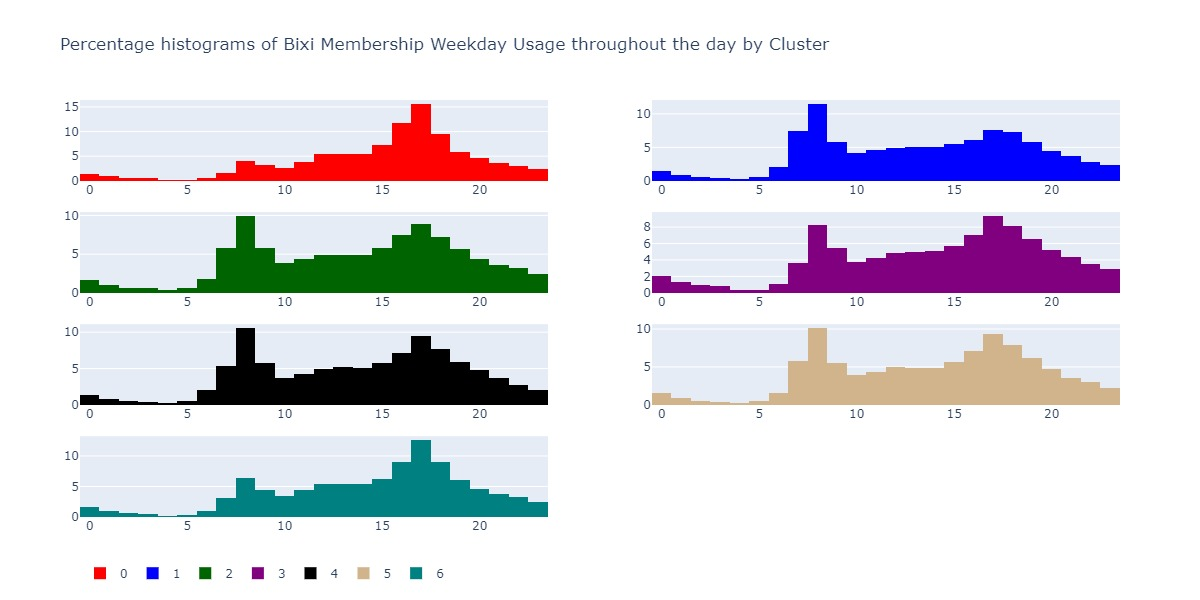

In [32]:
data = pd.merge(data,clusteringData[['Code','label']],left_on='start_station_code',right_on='Code')
fig = make_subplots(rows=4, cols=2)

rowsCols = [(1,1),(1,2),(2,1),(2,2),(3,1),(3,2),(4,1)]
clusterLabels = np.sort(data['label'].unique())
randomColourList = ['red','blue','darkgreen','purple','black',
                    'tan','teal','gold','orange','scarlet']


for clusterLabel,color,rowCol in zip(clusterLabels,randomColourList,rowsCols):
    fig.add_trace(go.Histogram(
            x=data.loc[data['label']==clusterLabel,'tripStartHour'],
            marker_color=color,
            histnorm='percent',
            name=str(clusterLabel)),
        row=rowCol[0],col=rowCol[1])

fig.update_layout(title='Percentage histograms of Bixi Membership Weekday Usage throughout the day by Cluster ',
                 legend_orientation='h')

# fig.update_layout(height=800,width=1600)

# fig.show()
Image(fig.to_image(format="jpg",width=1200,height=600))

Those usage patterns support our hypotheses above.

### Summary Results, Thoughts, and Possible Next Steps

I can summarize my findings as follows:

* Membership ridership is extremely important to the Bixi system. It is important to understand what this customer base likes about Bixi and ensure that they continue to be served as needed. Furthermore, if the reasons for using the system are not intrinsic in the users, it is important for the system to find ways to attract more users to become members.

* There are clear usage patterns across several clusters that give us cluse as to how Montrealers use the system and the commuter patterns they follow. Such information is surely of great interest to policymakers, urban planners, transit authorities, and other stakeholders.

I realize that conducting analysis and throwing out "inconvenient" data is not the best way to approach any data analysis problem, and it is one of the major weaknesses of my analysis. However, by ensuring using a somewhat objective measure to determine which stations should interest us somewhat tempers that concern. In a future analysis, it may be possible to discard the "bulk" that I performed my analysis on here and run the "noise" stations data through a similar analysis to find if there are usage patterns across different "noisy" clusters. Given their geographic isolation, such an analysis might be even more suited to those stations.

Given that clustering is very prone to providing spurious conclusions, it is even more necessary to conduct sanity checks and test the robustness of our findings. In the future, I would like to confirm my findings by examining the data based on where trips end. If the findings from that analysis somewhat match our findings here, we can be more confident of both.

The city of Montreal also provides [data](http://donnees.ville.montreal.qc.ca/dataset/pistes-cyclables) on biking infrastructure. I aim to use that data to examine the effects of biking infrastructure on residents' decisions to get around using a bike. 